# Dive into it !!!
Text classification is a popular task in Natural Language Processing (NLP), with applications ranging from categorizing customer feedback to filtering spam emails. Another common application is sentiment analysis, which identifies the sentiment polarity in a given text. For instance, a company like Tesla might use sentiment analysis to gauge public opinion on its new car roofs from Twitter posts.


We will also introduce three core libraries from the Hugging Face ecosystem: Datasets, Tokenizers, and Transformers.
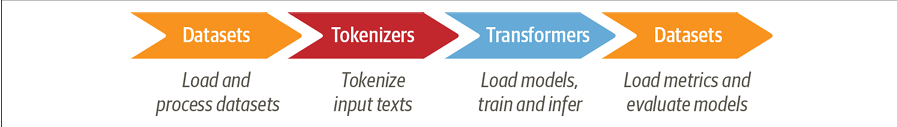

In this study guide, we will employ the BertForTokenClassification model, a component of the Transformers library developed by HuggingFace. This model is built upon the BERT architecture, featuring an additional token classification head. This enhancement enables the model to perform predictions at the token level, instead of the sequence level, making it an ideal choice for tasks like named entity recognition, which we will be focusing on.

The concept of transfer learning is the backbone of this guide. This involves pretraining a vast neural network in an unsupervised manner, followed by fine-tuning the network for a specific task. In our case, BERT, a neural network pretrained on masked language modeling and next sentence prediction tasks, will be fine-tuned using a Named Entity Recognition (NER) dataset. Please note that fine-tuning is a form of supervised learning, hence, a labeled dataset is required.

For a deeper understanding of BERT, consider exploring these resources:


The original research paper
Jay Allamar's insightful blog post and tutorial
Chris Mccormick's informative Youtube channel
Abhishek Kumar Mishra's educational Youtube channel
This guide mirrors the structure of Abhishek Kumar Mishra's tutorials, available on his Github repository.

Please note that this guide presumes a fundamental understanding of deep learning, BERT, and native PyTorch. If you wish to enhance your knowledge in Python, deep learning, and PyTorch, I strongly recommend checking out cs231n by Stanford University and the FastAI course by Jeremy Howard and his team, both of which are accessible online for free.

Now, let's dive into the practical aspects!

In [1]:
!pip install transformers seqeval[gpu]
!pip install pandas
!pip install numpy
!pip install -U scikit-learn
!pip install pytorch
!pip install transformers
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 391.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=69c43593ef412c703efe3370c5bc2c56f3c6fa2f5039bc7a7984932abad12faa
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

As deep learning can be accellerated a lot using a GPU instead of a CPU, make sure you can run this notebook in a GPU runtime (which Google Colab provides for free! - check "Runtime" - "Change runtime type" - and set the hardware accelerator to "GPU").

We can set the default device to GPU using the following code (if it prints "cuda", it means the GPU has been recognized):

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


Named Entity Recognition (NER) employs a particular annotation scheme, which is typically defined at the word level for European languages. A popular annotation scheme is IOB-tagging, an acronym for Inside-Outside-Beginning. Each tag specifies whether the associated word is inside, outside, or at the beginning of a named entity. This scheme is utilized because named entities often consist of more than one word.

Let's examine an example. For a sentence like "Barack Obama was born in Hawaï", the corresponding tags would be [B-PERS, I-PERS, O, O, O, B-GEO]. Here, B-PERS signifies that "Barack" is the beginning of a person's name, I-PERS indicates that "Obama" is inside a person's name, "O" means that "was" is outside any named entity, and so forth. Typically, the number of tags equals the number of words in a sentence.

Training a deep learning model for NER necessitates having your data in the IOB format (or similar formats like BILOU). There are numerous annotation tools available that can automatically create these annotations for you, such as Spacy's Prodigy, Tagtog, or Doccano. Additionally, you can use Spacy's biluo_tags_from_offsets function to transform character-level annotations to the IOB format.

In this study, we will utilize a NER dataset from Kaggle that is already in the IOB format. To access it, visit this webpage, download the dataset, extract it, and upload the CSV file to this notebook. Let's display the initial rows of this CSV file:

In [6]:
data = pd.read_csv("/content/drive/MyDrive/kaggle_data/ner_datasetreference.csv", encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's check how many sentences and words (and corresponding tags) there are in this dataset:

In [7]:
data.count()

Sentence #      47959
Word          1048565
POS           1048575
Tag           1048575
dtype: int64

As we can see, there are approximately 48,000 sentences in the dataset, comprising more than 1 million words and tags (quite huge!). This corresponds to approximately 20 words per sentence.

Let's have a look at the different NER tags, and their frequency:

In [8]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 17


Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [9]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36927), ('per', 34241), ('tim', 26861), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


Let's remove "art", "eve" and "nat" named entities, as performance on them will probably be not comparable to the other named entities.

In [10]:
entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
data = data[~data.Tag.isin(entities_to_remove)]
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


Now, we need to consider: what constitutes a training example in the context of NER, which is processed in a single forward pass? In general, a training example is a sentence accompanied by its corresponding IOB tags. Let's organize the words and their associated tags by sentence:

In [11]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [12]:
# let's create a new column called "sentence" which groups the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 1,Thousands,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Sentence: 1,of,IN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
3,Sentence: 1,have,VBP,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
4,Sentence: 1,marched,VBN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."


Let's have a look at the different NER tags.

We create 2 dictionaries: one that maps individual tags to indices, and one that maps indices to their individual tags. This is necessary in order to create the labels (as computers work with numbers = indices, rather than words = tags) - see further in this notebook.

In [13]:
label2id = {k: v for v, k in enumerate(data.Tag.unique())}
id2label = {v: k for v, k in enumerate(data.Tag.unique())}
label2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-gpe': 9,
 'I-tim': 10}

As we can see, there are now only 10 different tags.

Let's only keep the "sentence" and "word_labels" columns, and drop duplicates:

In [14]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


In [15]:
len(data)

47571

Let's verify that a random sentence and its corresponding tags are correct:

In [32]:
data.iloc[52].sentence

'But he says Pakistan is not ready to make the nuclear scientist , Abdul Qadeer Khan , available for direct questioning over his sale of nuclear parts and secrets to states including Iran , Libya and North Korea .'

In [33]:
data.iloc[52].word_labels

'O,O,O,B-gpe,O,O,O,O,O,O,O,O,O,B-per,I-per,I-per,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-gpe,O,B-gpe,O,B-gpe,I-gpe,O'

#### **Preparing the dataset and dataloader**

Now that our data is preprocessed, we can turn it into PyTorch tensors such that we can provide it to the model. Let's start by defining some key variables that will be used later on in the training/evaluation process:

In [47]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

A tricky part of NER with BERT is that BERT relies on **wordpiece tokenization**, rather than word tokenization. This means that we should also define the labels at the wordpiece-level, rather than the word-level!

For example, if you have word like "Washington" which is labeled as "b-gpe", but it gets tokenized to "Wash", "##ing", "##ton", then we will have to propagate the word’s original label to all of its wordpieces: "b-gpe", "b-gpe", "b-gpe". The model should be able to produce the correct labels for each individual wordpiece. The function below (taken from [here](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L118)) implements this.






In [34]:
def tokenize_and_maintain_labels(input_string, associated_labels, tokenizer):
    """
    This function performs tokenization on each word individually to ensure that
    the correct label is preserved for each subword. This is because word piece
    tokenization can make it challenging to align word labels with their respective
    subwords. Although this approach may take longer to process, it will enhance
    the accuracy of our model.
    """

    tokenized_input = []
    corresponding_labels = []

    input_string = input_string.strip()

    for word, label in zip(input_string.split(), associated_labels.split(",")):

        # Perform tokenization on the word and determine the number of subwords
        tokenized_word = tokenizer.tokenize(word)
        subword_count = len(tokenized_word)

        # Append the tokenized word to the final list of tokenized words
        tokenized_input.extend(tokenized_word)

        # Append the label to the list of labels, repeating it for each subword
        corresponding_labels.extend([label] * subword_count)

    return tokenized_input, corresponding_labels


Note that this is a **design decision**. You could also decide to only label the first wordpiece of each word and let the model only learn this (this is what was done in the original BERT paper, see Github discussion [here](https://github.com/huggingface/transformers/issues/64#issuecomment-443703063)). Another design decision could be to give the first wordpiece of each word the original word label, and then use the label “X” for all subsequent subwords of that word.

All of them lead to good performance.

Next, we define a regular PyTorch [dataset class](https://pytorch.org/docs/stable/data.html) (which transforms examples of a dataframe to PyTorch tensors). Here, each sentence gets tokenized, the special tokens that BERT expects are added, the tokens are padded or truncated based on the max length of the model, the attention mask is created and the labels are created based on the dictionary which we defined above.

For more information about BERT's inputs, see [here](https://huggingface.co/transformers/glossary.html).  

In [35]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_maintain_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

Now, based on the class we defined above, we can create 2 datasets, one for training and one for testing. Let's use a 80/20 split:

In [36]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (47571, 2)
TRAIN Dataset: (38057, 2)
TEST Dataset: (9514, 2)


Let's have a look at the first training example:

In [37]:
training_set[0]

{'ids': tensor([  101, 23564, 21030,  2099,  4967,  2001,  9388,  1011,  6109,  2005,
          2634,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

Let's verify that the input ids and corresponding targets are correct:

In [38]:
training_set[0]["ids"]

tensor([  101, 23564, 21030,  2099,  4967,  2001,  9388,  1011,  6109,  2005,
         2634,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [39]:
# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:30]), training_set[0]["targets"][:30]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
za          B-per
##hee       B-per
##r         B-per
khan        I-per
was         O
mar         O
-           O
93          O
for         O
india       B-geo
.           O
[SEP]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O
[PAD]       O


Now, let's define the corresponding PyTorch dataloaders:

In [40]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

#### **Defining the model**

Here we define the model, BertForTokenClassification, and load it with the pretrained weights of "bert-base-uncased". The only thing we need to additionally specify is the number of labels (as this will determine the architecture of the classification head).

Note that only the base layers are initialized with the pretrained weights. The token classification head of top has just randomly initialized weights, which we will train, together with the pretrained weights, using our labelled dataset. This is also printed as a warning when you run the code cell below.

Then, we move the model to the GPU.

In [41]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

#### **Training the model**

Before training the model, let's perform a sanity check, which I learned thanks to Andrej Karpathy's wonderful [cs231n course](http://cs231n.stanford.edu/) at Stanford (see also his [blog post about debugging neural networks](http://karpathy.github.io/2019/04/25/recipe/)). The initial loss of your model should be close to -ln(1/number of classes) = -ln(1/11) = 2.53.

Why? Because we are using cross entropy loss. The cross entropy loss is defined as -ln(probability score of the model for the correct class). In the beginning, the weights are random, so the probability distribution for all of the classes for a given token will be uniform, meaning that the probability for the correct class will be near 1/11. The loss for a given token will thus be -ln(1/11). As PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (which is used by `BertForTokenClassification`) uses *mean reduction* by default, it will compute the mean loss for each of the tokens in the sequence (in other words, for all of the 512 tokens). The mean of 512 times -log(1/11) is, you guessed it, -log(1/11).  

Let's verify this:



In [42]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.5922, device='cuda:0', grad_fn=<NllLossBackward0>)

This looks good. Let's also verify that the logits of the neural network have a shape of (batch_size, sequence_length, num_labels):

In [43]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 11])

Next, we define the optimizer. Here, we are just going to use Adam with a default learning rate. One can also decide to use more advanced ones such as AdamW (Adam with weight decay fix), which is [included](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) in the Transformers repository, and a learning rate scheduler, but we are not going to do that here.

In [44]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Now let's define a regular PyTorch training function. It is partly based on [a really good repository about multilingual NER](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344).

In [45]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

And let's train the model!

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 0.21238429844379425
Training loss per 100 training steps: 0.13552749887256338
Training loss per 100 training steps: 0.12086367178059633
Training loss per 100 training steps: 0.10818846996539455
Training loss per 100 training steps: 0.09961154992620175
Training loss per 100 training steps: 0.09304017271891148


#### **Evaluating the model**

Now that we've trained our model, we can evaluate its performance on the held-out test set (which is 20% of the data). Note that here, no gradient updates are performed, the model just outputs its logits.

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

As we can see below, performance is quite good! Accuracy on the test test is > 93%.

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.0006468583596870303
Validation loss per 100 evaluation steps: 0.029117425034885378
Validation loss per 100 evaluation steps: 0.02645552399816149
Validation loss per 100 evaluation steps: 0.02677391133851494
Validation loss per 100 evaluation steps: 0.02708561681612352
Validation loss per 100 evaluation steps: 0.027608126274245224
Validation loss per 100 evaluation steps: 0.02766878997025017
Validation loss per 100 evaluation steps: 0.02802180213946799
Validation loss per 100 evaluation steps: 0.02813900749804568
Validation loss per 100 evaluation steps: 0.02800608498731886
Validation loss per 100 evaluation steps: 0.0283729030002046
Validation loss per 100 evaluation steps: 0.02819417062155819
Validation loss per 100 evaluation steps: 0.028217743144274266
Validation loss per 100 evaluation steps: 0.028680528649606803
Validation loss per 100 evaluation steps: 0.02914536368688233
Validation loss per 100 evaluation steps: 0.02904094562052864
Val

However, the accuracy metric is misleading, as a lot of labels are "outside" (O), even after omitting predictions on the [PAD] tokens. What is important is looking at the precision, recall and f1-score of the individual tags. For this, we use the seqeval Python library:

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         geo       0.79      0.88      0.83      4613
         gpe       0.89      0.89      0.89      1523
         org       0.71      0.56      0.63      2761
         per       0.78      0.81      0.79      2183
         tim       0.82      0.81      0.81      1772

   micro avg       0.79      0.79      0.79     12852
   macro avg       0.80      0.79      0.79     12852
weighted avg       0.79      0.79      0.79     12852



#### **Inference**

The fun part is when we can quickly test the model on new, unseen sentences.
Here, we use the prediction of the **first word piece of every word**. Note that the function we used to train our model (`tokenze_and_preserve_labels`) propagated the label to all subsequent word pieces (so you could for example also perform a majority vote on the predicted labels of all word pieces of a word).

*In other words, the code below does not take into account when predictions of different word pieces that belong to the same word do not match.*

In [ ]:
sentence = "India has a capital called Mumbai. On wednesday, the president will give a presentation"

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

india has a capital called mumbai . on wednesday , the president will give a presentation
['B-geo', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Note that there's another way to easily perform quick inference with a trained model: the [pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines). The pipeline API abstracts away all the complexity for you (basically performing what we did above). Here, we'll use the [TokenClassificationPipeline](https://huggingface.co/docs/transformers/v4.17.0/en/main_classes/pipelines#transformers.TokenClassificationPipeline) since that's the task we're doing, and we provide a model and tokenizer.

In [ ]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("My name is Niels and New York is a city")

[{'end': None,
  'entity_group': 'per',
  'score': 0.71306735,
  'start': None,
  'word': 'ni'},
 {'end': None,
  'entity_group': 'per',
  'score': 0.8921481,
  'start': None,
  'word': '##els'},
 {'end': None,
  'entity_group': 'geo',
  'score': 0.95278734,
  'start': None,
  'word': 'new york'}]

#### **Saving the model for future use**

Finally, let's save the model and tokenizer files such that we can easily re-use them later on. There are 2 options:

* you can save everything locally, simply by calling `model.save_pretrained()` and `tokenizer.save_pretrained()`, providing a directory path as argument.
* you can push the files to the [HuggingFace hub](https://huggingface.co/). This way, you can share your model with the community/your colleagues. All files will be tracked by git, as each model on the hub has its own git repo.

Both options allow to re-use the model/tokenizer using the `from_pretrained()` method. Here we'll do the latter.

To upload a model to the hub, 2 things need to be setup:
* install git-LFS, which is used by the hub
* set up authentication token


In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (899 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155332 files and directories cur

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
model_name = "bert-finetuned-ner"

# upload files to the hub
tokenizer.push_to_hub(
    repo_path_or_name=model_name,
    organization="nielsr",
    commit_message="Add tokenizer",
    use_temp_dir=True,
)
model.push_to_hub(
    repo_path_or_name=model_name,
    organization="nielsr",
    commit_message="Add model",
    use_temp_dir=True,
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/nielsr/bert-finetuned-ner into local empty directory.
To https://huggingface.co/nielsr/bert-finetuned-ner
   7fb33a6..12404bd  main -> main

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/nielsr/bert-finetuned-ner into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.39k/415M [00:00<?, ?B/s]

To https://huggingface.co/nielsr/bert-finetuned-ner
   12404bd..77117f5  main -> main



'https://huggingface.co/nielsr/bert-finetuned-ner/commit/77117f560fc015ea11bb2b1f0496bfc09cf792b3'

You can check the model on the hub: https://huggingface.co/nielsr/bert-finetuned-ner. Awesome, isn't it? Check the "files and versions" tab, it includes all our files :) we can now load it back as follows (here I'm using the [Auto API](https://huggingface.co/docs/transformers/model_doc/auto) - which will load the appropriate tokenizer + model for us):

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_name = "nielsr/bert-finetuned-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/369 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]